In [2]:
import numpy as np
import pandas as pd

import warnings; 
warnings.filterwarnings("ignore")

# Visualizations
import seaborn as sns 
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

# Text processing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# algorithm
from sklearn.linear_model import SGDClassifier

<h3>Load data</h3> 

In [3]:
path_data = '../../../yelp_academic_dataset_review.pickle'
data = pd.read_pickle(path_data)

In [4]:
# Removing all ('\n') characters using list comprehensions
data['text'] = [txt.replace('\n', '') for txt in data['text']]

# Taking only text and stars columns
data = data.loc[:, ['text', 'stars']]

<h3>Tokenizer</h3>

In [ ]:
#data["tokens"] = data.apply(lambda row: word_tokenize(row["text"]), axis=1)

#data.head()

<h3>Text representation</h3>

The classifiers and learning algorithms can not directly process the text documents in their original form, as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length. Therefore, during the preprocessing step, the texts are converted to a more manageable representation.

In [5]:
X = data["text"].tolist()
y = data["stars"].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def count_vectorize(data):
    count_vectorizer = CountVectorizer()
    
    embedding = count_vectorizer.fit_transform(data)
    
    return embedding, count_vectorizer

def tfidf_transform(data):
    tfidf_transformer = TfidfTransformer()
    
    text_freq = tfidf_transformer.fit_transform(data)
    
    return text_freq, tfidf_transformer

X_train_counts, count_vectorizer = count_vectorize(X_train)
X_test_counts = count_vectorizer.transform(X_test)

X_train_tfidf, tfidf_transformer = tfidf_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

<h3>Tuning parameters</h3>

In [6]:
alpha_values=[1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
accuracy_means = []
accuracy_stdevs=[]
num_folds=5
seed=42

#temporary only a part of the data
X_train_tfidf_t=X_train_tfidf[:]
y_train_t=y_train[:]

for alpha_value in alpha_values:
    model = SGDClassifier(loss='hinge', penalty='l2', alpha=alpha_value, average=False, class_weight=None, epsilon=0.1,
    eta0=0.0, fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',  max_iter=5, n_iter=None, n_jobs=1, power_t=0.5, 
    random_state=42, shuffle=True, tol=None, verbose=0, warm_start=False)
    
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train_tfidf_t, y_train_t, scoring='accuracy', cv=kfold)
    accuracy_means.append(cv_results.mean())
    accuracy_stdevs.append(cv_results.std())
    
for accuracy_mean, accuracy_stdev, alpha_value in zip(accuracy_means, accuracy_stdevs, alpha_values):
    print("%f (%f) with n_trees : %r" % (accuracy_mean, accuracy_stdev, alpha_value))

0.556845 (0.002376) with n_trees : 1e-07
0.600411 (0.002297) with n_trees : 1e-06
0.594109 (0.001143) with n_trees : 1e-05
0.555544 (0.001238) with n_trees : 0.0001
0.504896 (0.001676) with n_trees : 0.001
0.476975 (0.003381) with n_trees : 0.01
0.369376 (0.000895) with n_trees : 0.1


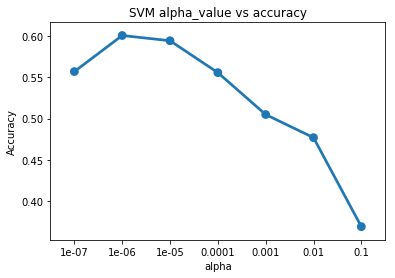

In [7]:
sns.pointplot(x=alpha_values, y=accuracy_means)
plt.title("SVM alpha_value vs accuracy")
plt.xlabel("alpha")
plt.ylabel("Accuracy")
plt.savefig("SVM_SGD.png")

<h3>Testing Data<h3>

In [8]:
best_alpha=alpha_values[0]
best_accuracy=accuracy_means[0]
for i in range(len(alpha_values)):
    if accuracy_means[i]>best_accuracy:
        best_accuracy=accuracy_means[i]
        best_alpha=alpha_values[i]

svm_clf = SGDClassifier(loss='hinge', penalty='l2', alpha=best_alpha, average=False, class_weight=None, epsilon=0.1,
    eta0=0.0, fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',  max_iter=5, n_iter=None, n_jobs=1, power_t=0.5, 
    random_state=42, shuffle=True, tol=None, verbose=0, warm_start=False).fit(X_train_tfidf,y_train)
svm_clf.score(X_test_tfidf,y_test)

0.60388462114429364